# Projeto 2 de Ciência dos Dados

Integrantes:
- Barbara Martins Damasceno
- Daniel Costa Delattre 
- Guilherme Augusto Carvalho

## Objetivo 
**Pergunta que queremos responder**
Qual é o preço de uma casa de acordo com suas características?

Carregando algumas bibliotecas:

In [17]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import os, csv, string, re
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [18]:
### Função utilitária para fazer a regressão com constante adicionada
def regress(X,Y):
    '''
    X: coluna(s) do DataFrame que serão utilizadas como variável(is) preditoras/explicativas (independente(s))
    Y: coluna do DataFrame que será utilizada como variável resposta (dependente)
    '''
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    return results

Verificando o diretório

In [19]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
C:\Users\guilherme\Desktop\house-prediction-cdados


Carregando a base de dados de teste e de treino:

In [20]:
dados= pd.read_csv('kc_house_data.csv')
#dadosteste = pd.read_csv('t1.xlsx', sheet_name='Teste')

Verificando se não existe linhas sem dados/informação

In [21]:
np.sum(dados.isnull())

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [22]:
dados.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [23]:
dados.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


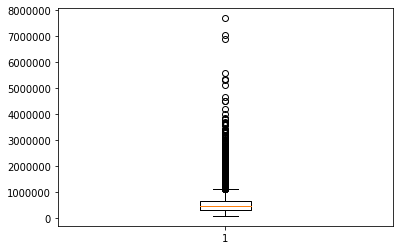

In [24]:
plt.boxplot(dados['price'])
plt.show()

Text(0, 0.5, 'Número de banheiros')

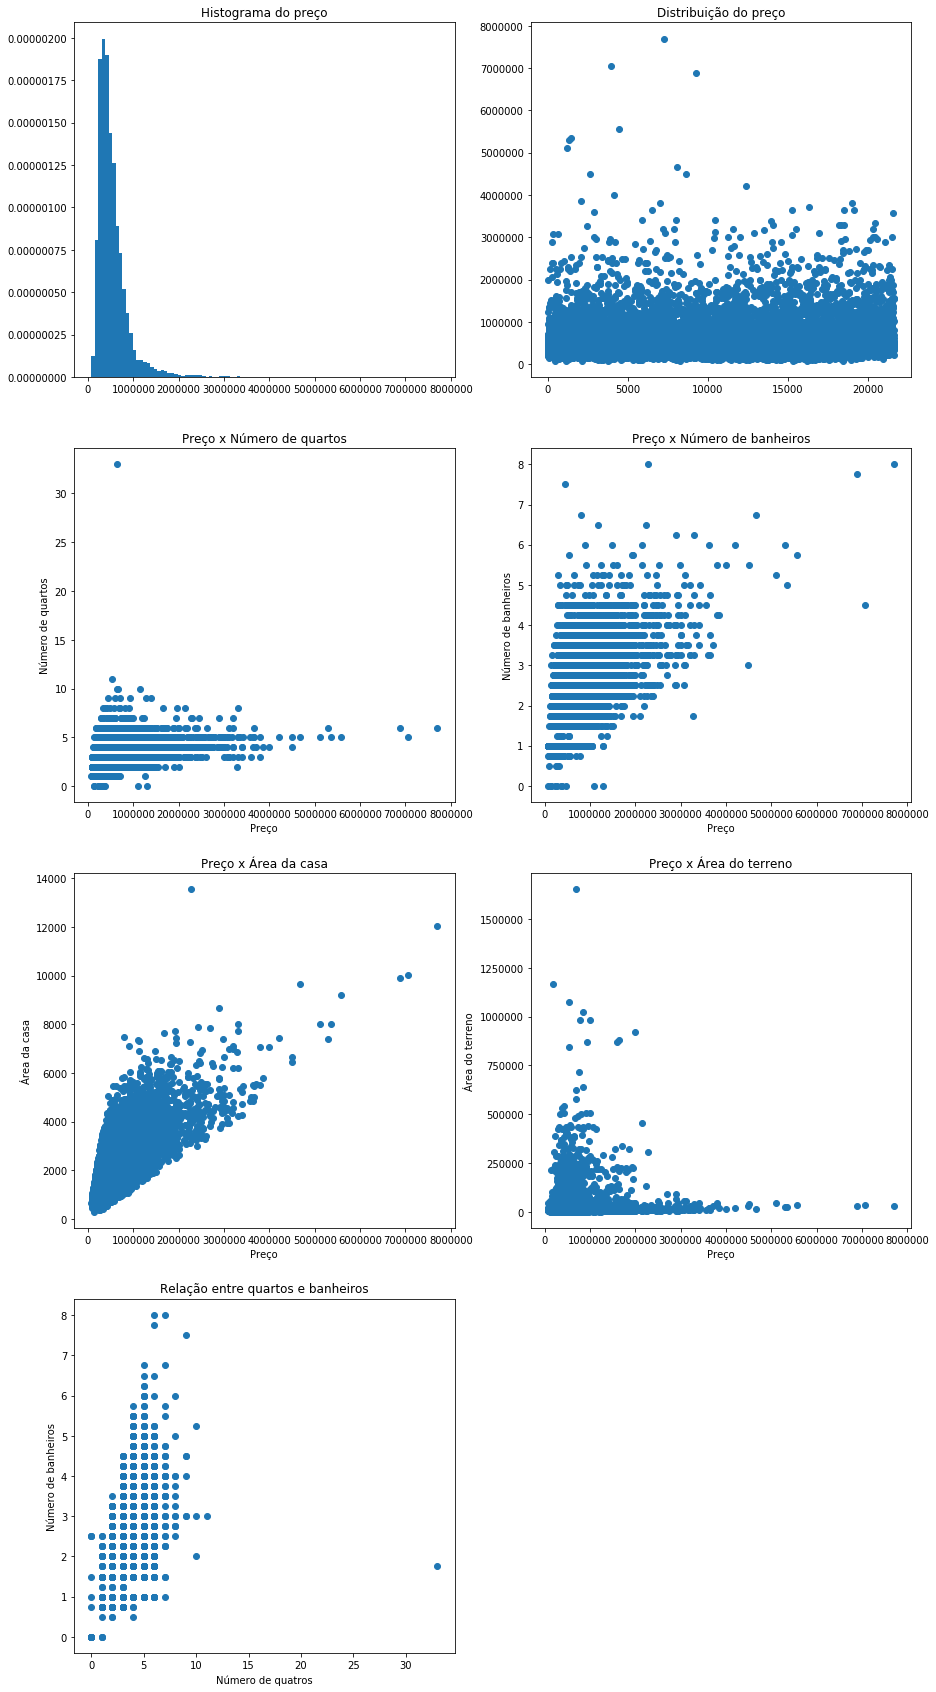

In [25]:
#Plotando as informações em gráficos
fig = plt.figure(figsize=(15, 30))

plt.subplot(4, 2, 1)
plt.hist(dados.price,bins=100,density=True)
plt.title('Histograma do preço')

plt.subplot(4, 2, 2)
faixa_aleatoria = np.arange(0,len(dados.price),1)
plt.scatter(faixa_aleatoria,dados.price)
plt.title('Distribuição do preço')

plt.subplot(4,2,3)
plt.scatter(dados.price, dados.bedrooms)
plt.title('Preço x Número de quartos')
plt.xlabel('Preço')
plt.ylabel('Número de quartos')

plt.subplot(4,2,4)
plt.scatter(dados.price, dados.bathrooms)
plt.title('Preço x Número de banheiros')
plt.xlabel('Preço')
plt.ylabel('Número de banheiros')

plt.subplot(4,2,5)
plt.scatter(dados.price, dados.sqft_living)
plt.title('Preço x Área da casa')
plt.xlabel('Preço')
plt.ylabel('Área da casa')

plt.subplot(4,2,6)
plt.scatter(dados.price, dados.sqft_lot)
plt.title('Preço x Área do terreno')
plt.xlabel('Preço')
plt.ylabel("Área do terreno")

plt.subplot(4,2,7)
plt.scatter(dados.bedrooms, dados.bathrooms)
plt.title('Relação entre quartos e banheiros')
plt.xlabel('Número de quatros')
plt.ylabel('Número de banheiros')



In [26]:
X = dados[['bedrooms', 'bathrooms', 'sqft_living','waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long']]
Y = dados['price']

In [27]:
X.corr()

,bedrooms,bathrooms,sqft_living,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long
bedrooms,1.000000,0.515884,0.576671,-0.006582,0.079532,0.028472,0.356967,0.477600,0.303093,0.154178,0.018841,-0.008931,0.129473
bathrooms,0.515884,1.000000,0.754665,0.063744,0.187737,-0.124982,0.664983,0.685342,0.283770,0.506019,0.050739,0.024573,0.223042
sqft_living,0.576671,0.754665,1.000000,0.103818,0.284611,-0.058753,0.762704,0.876597,0.435043,0.318049,0.055363,0.052529,0.240223
waterfront,-0.006582,0.063744,0.103818,1.000000,0.401857,0.016653,0.082775,0.072075,0.080588,-0.026161,0.092885,-0.014274,-0.041910
view,0.079532,0.187737,0.284611,0.401857,1.000000,0.045990,0.251321,0.167649,0.276947,-0.053440,0.103917,0.006157,-0.078400
condition,0.028472,-0.124982,-0.058753,0.016653,0.045990,1.000000,-0.144674,-0.158214,0.174105,-0.361417,-0.060618,-0.014941,-0.106500
grade,0.356967,0.664983,0.762704,0.082775,0.251321,-0.144674,1.000000,0.755923,0.168392,0.446963,0.014414,0.114084,0.198372
sqft_above,0.477600,0.685342,0.876597,0.072075,0.167649,-0.158214,0.755923,1.000000,-0.051943,0.423898,0.023285,-0.000816,0.343803
sqft_basement,0.303093,0.283770,0.435043,0.080588,0.276947,0.174105,0.168392,-0.051943,1.000000,-0.133124,0.071323,0.110538,-0.144765
yr_built,0.154178,0.506019,0.318049,-0.026161,-0.053440,-0.361417,0.446963,0.423898,-0.133124,1.000000,-0.224874,-0.148122,0.409356


In [28]:
results = regress(X,Y)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     4085.
Date:                Thu, 04 Jun 2020   Prob (F-statistic):               0.00
Time:                        14:37:19   Log-Likelihood:            -2.9480e+05
No. Observations:               21613   AIC:                         5.896e+05
Df Residuals:                   21600   BIC:                         5.897e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -3.561e+07   1.49e+06    -23.826      0.000   -3.85e+07   -3.27e+07
bedrooms      -3.353e+04   1898.199    -17.664      0.000   -3.72e+04   -2.98e+04
bathrooms      4.157e+04   3160.679     13.153      0.000    3.54e+04    4.78e+04
sqft_living     113.8916      2.107     54.056      0.000     109.762     118.021
waterfront     5.835e+05   1.75e+04     33.327      0.000    5.49e+05    6.18e+05
view           5.167e+04   2123.805     24.330      0.000    4.75e+04    5.58e+04
condition      3.042e+04   2351.818     12.936      0.000    2.58e+04     3.5e+04
grade          1.023e+05   2074.293     49.337      0.000    9.83e+04    1.06e+05
sqft_above       75.0437      2.009     37.360      0.000      71.107      78.981
sqft_basement    38.8481      2.424     16.028      0.000      34.097      43.599
yr_built      -2471.8056     70.928    -34.849      0.000   -2610.831   -2332.781
yr_renovated     19.7531      3.677      5.373      0.000      12.547      26.960
lat            5.655e+05   1.05e+04     53.994      0.000    5.45e+05    5.86e+05
long          -1.052e+05   1.13e+04     -9.319      0.000   -1.27e+05   -8.31e+04
==============================================================================
Omnibus:                    18252.919   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1750157.662
Skew:                           3.544   Prob(JB):                         0.00
Kurtosis:                      46.511   Cond. No.                     1.16e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is  2e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

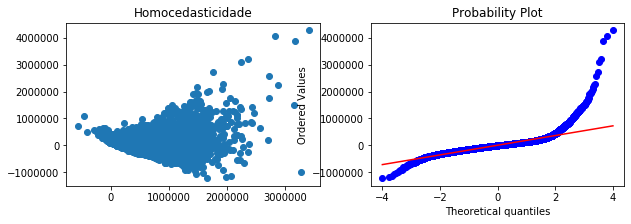

In [29]:
resultado_reg = results.resid

y_predict = results.predict(sm.add_constant(X))

fig1 = plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.scatter(y_predict,resultado_reg)
plt.title("Homocedasticidade")

plt.subplot(1,2,2)
stats.probplot(resultado_reg,dist='norm',plot=plt)
plt.show()

In [30]:
features = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'sqft_living15', 'sqft_lot15',
       'lat', 'long',]

In [31]:
y = dados.price
x = dados[features]

xtreino,xvalidacao,ytreino,yvalidacao = train_test_split(x, y, random_state=1)

In [32]:
# Especificando o modelo
modelo_decisiontree = DecisionTreeRegressor()
# Fit do modelo 
modelo_decisiontree.fit(xtreino, ytreino)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [33]:
# Faz a previsão do preço das casas e calcula a média dos erros com base 
val_predictions = modelo_decisiontree.predict(xvalidacao)
val_mae = mean_absolute_error(val_predictions, yvalidacao)
print(f'MAE: {val_mae:.2f}')

MAE: 99651.81


In [34]:
#modelo usando random forest 
modelo_randomforest = RandomForestRegressor(random_state=1)
modelo_randomforest.fit(xtreino, ytreino)
rf_predict = modelo_randomforest.predict(xvalidacao)
rf_mae = mean_absolute_error(rf_predict, yvalidacao)

print(f'Random Forest MAE: {rf_mae:.2f}')

Random Forest MAE: 71013.02
